In [1]:
import h5py, os

import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from skimage.measure import compare_ssim

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

### Transforms

In [2]:
def tensor_to_complex_np(data):

    data = data.numpy()
    return data[..., 0] + 1j * data[..., 1]


def to_tensor(data):

    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)
    return torch.from_numpy(data)


def apply_mask(data, mask_func, seed=None):

    shape = np.array(data.shape)
    shape[:-3] = 1
    mask = mask_func(shape, seed)
    return torch.where(mask == 0, torch.Tensor([0]), data), mask


def fft2(data):

    assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = torch.fft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def ifft2(data):

    assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = torch.ifft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def complex_abs(data):

    assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1).sqrt()


def root_sum_of_squares(data, dim=0):

    return torch.sqrt((data ** 2).sum(dim))


def center_crop(data, shape):

    assert 0 < shape[0] <= data.shape[-2]
    assert 0 < shape[1] <= data.shape[-1]
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]


def complex_center_crop(data, shape):

    assert 0 < shape[0] <= data.shape[-3]
    assert 0 < shape[1] <= data.shape[-2]
    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to, :]


def normalize(data, mean, stddev, eps=0.):

    return (data - mean) / (stddev + eps)


def normalize_instance(data, eps=0.):

    mean = data.mean()
    std = data.std()
    return normalize(data, mean, std, eps), mean, std
    

def roll(x, shift, dim):

    if isinstance(shift, (tuple, list)):
        assert len(shift) == len(dim)
        for s, d in zip(shift, dim):
            x = roll(x, s, d)
        return x
    shift = shift % x.size(dim)
    if shift == 0:
        return x
    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)
    return torch.cat((right, left), dim=dim)


def fftshift(x, dim=None):

    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [dim // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = x.shape[dim] // 2
    else:
        shift = [x.shape[i] // 2 for i in dim]
    return roll(x, shift, dim)


def ifftshift(x, dim=None):

    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [(dim + 1) // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = (x.shape[dim] + 1) // 2
    else:
        shift = [(x.shape[i] + 1) // 2 for i in dim]
    return roll(x, shift, dim)

### Subsample mask

In [3]:
class MaskFunc:

    def __init__(self, center_fractions, accelerations):
       
        if len(center_fractions) != len(accelerations):
            raise ValueError('Number of center fractions should match number of accelerations')

        self.center_fractions = center_fractions
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def __call__(self, shape, seed=None):

        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')

        self.rng.seed(seed)
        num_cols = shape[-2]

        choice = self.rng.randint(0, len(self.accelerations))
        center_fraction = self.center_fractions[choice]
        acceleration = self.accelerations[choice]

        num_low_freqs = int(round(num_cols * center_fraction))
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = self.rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))

        return mask

### Data loader

In [4]:
def load_data_path(train_data_path, val_data_path):

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):
        data_list[train_and_val[i]] = [] 
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            subject_data_path = os.path.join(which_data_path, fname)
            if not os.path.isfile(subject_data_path): continue
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
            
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]

    return data_list

In [5]:
class MRIDataset(DataLoader):

    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list) 

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

### Preprocessing

In [6]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):

    fname, rawdata_path, slice = subject_id
    
    with h5py.File(rawdata_path, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape
    shape = np.array(slice_kspace.shape)

    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)
    
    img_und = ifft2(masked_kspace)
    img_und = complex_center_crop(img_und, [320, 320])
    img_und = complex_abs(img_und)
    norm = img_und.max()
    
    img_und, mean, std = normalize_instance(img_und, eps=1e-11)
    img_und = img_und.clamp(-6, 6)
    
    img_gt = ifft2(slice_kspace)
    img_gt = complex_center_crop(img_gt, [320, 320])
    img_gt = complex_abs(img_gt)
    img_gt = normalize(img_gt, mean, std, eps=1e-11)
    img_gt = img_gt.clamp(-6, 6)
    
    return img_gt, img_und, masked_kspace.squeeze(0), masks.squeeze(0), mean, std, norm

### Metrics

In [7]:
def ssim(gt, pred):

    return compare_ssim(gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), 
                        multichannel=True, data_range=gt.max())

### Reconstruction

In [8]:
def reconstructions(test_loader, model_log):
    model.load_state_dict(torch.load(root + model_log))
    for iter, fname in enumerate(test_loader):
        output = model(images)

In [9]:
def save_reconstructions(reconstructions, out_dir):

    for fname, recons in reconstructions.items():
        subject_path = os.path.join(out_dir, fname)
        print(subject_path)
        with h5py.File(subject_path, 'w') as f:
            f.create_dataset('reconstruction', data=recons)

In [10]:
def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

### U-net model

In [11]:
class ConvBlock(nn.Module):


    def __init__(self, in_chans, out_chans, drop_prob):

        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_chans),
            nn.ReLU(),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):

        return self.layers(input)

    def __repr__(self):
        return f'ConvBlock(in_chans={self.in_chans}, out_chans={self.out_chans}, ' \
            f'drop_prob={self.drop_prob})'


class UnetModel(nn.Module):


    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):

        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch, drop_prob)

        self.up_sample_layers = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_sample_layers += [ConvBlock(ch * 2, ch // 2, drop_prob)]
            ch //= 2
        self.up_sample_layers += [ConvBlock(ch * 2, ch, drop_prob)]
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch, ch // 2, kernel_size=1),
            nn.Conv2d(ch // 2, out_chans, kernel_size=1),
            nn.Conv2d(out_chans, out_chans, kernel_size=1),
        )

    def forward(self, input):

        stack = []
        output = input
        # Apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2)

        output = self.conv(output)

        # Apply up-sampling layers
        for layer in self.up_sample_layers:
            output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=False)
            output = torch.cat([output, stack.pop()], dim=1)
            output = layer(output)
        return self.conv2(output)

### Training and validation

In [14]:
def train(num_epochs, interval, model_save, model_log):
        
    if not model_log is None:
        model.load_state_dict(torch.load(root + model_log))

    for epoch in range(1, num_epochs + 1):    
        model.train()
        
        avg_loss = 0
        train_loss = 0
        iter_loss = []
        
        for iteration, sample in enumerate(train_loader):
            img_gt, img_und, masked_kspace, masks, mean, std, norm = sample

            X = img_und
            Y = img_gt
            X, Y = X.to(device), Y.to(device)

            output = model(X)
            loss = F.mse_loss(output, Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = 0.99 * train_loss + 0.01 * loss.item() if iteration > 0 else loss.item()
            iter_loss.append(train_loss)

            if iteration % interval == 0:
                print(epoch, iteration, train_loss)
        
        avg_loss = np.mean(iter_loss)
        print('\nTrain Epoch: {} Average training loss: {:.4f} \n'.format(epoch, avg_loss))
        torch.save(model.state_dict(), root + model_save)


def val(model_log):

    model.load_state_dict(torch.load(root + model_log))
    model.eval()
    model.to(device)
    val_loss = []
    avg_loss = 0
    val_ssim = 0

    with torch.no_grad():
        for sample in val_loader:
            img_gt, img_und, masked_kspace, masks, mean, std, norm = sample
            
            show_slices(img_und.squeeze(0),[0])
            
            X = img_und
            Y = img_gt
            X, Y = X.to(device), Y.to(device)
            
            result = model(X)
            mean = mean.unsqueeze(1).unsqueeze(2).to(device)
            std = std.unsqueeze(1).unsqueeze(2).to(device)
            Y = Y * std + mean
            result = result * std + mean
            
            norm = norm.unsqueeze(1).unsqueeze(2).to(device)
            loss = mse_loss(result / norm, Y / norm, size_average=False)
            val_loss.append(loss.item())
                      
            result, Y = result.cpu(), Y.cpu()
            val_ssim += ssim(Y.squeeze(0).numpy(), result.squeeze(0).numpy())

    avg_loss = np.mean(val_loss)
    val_ssim /= len(val_dataset)
    print('\nAverage loss: {:.4f} \nAverage SSIM: {:.4f}'.format(avg_loss, val_ssim))

NameError: name 'mse_loss' is not defined

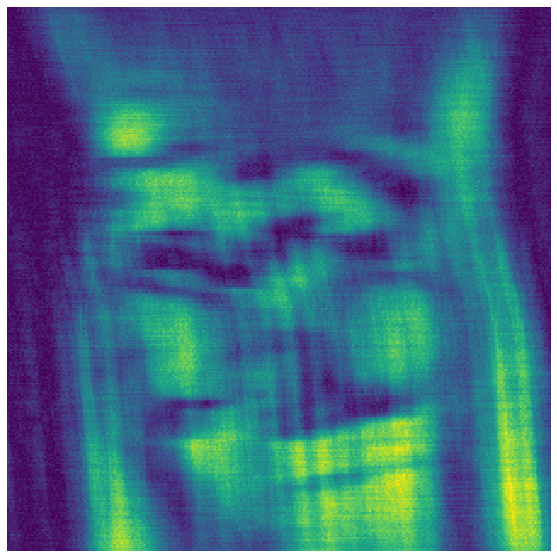

In [15]:
if __name__ == '__main__':
    
    root = '/home/kevinxu/NC2019MRI/fastMRI/models/'
    data_path_train = '/home/kevinxu/Documents/NC2019MRI/train/'
    data_path_val = '/home/kevinxu/Documents/NC2019MRI/train/'
    data_list = load_data_path(data_path_train, data_path_val)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    acc = 8
    cen_fract = 0.04 
    seed = False 
    num_batch = 1
    num_workers = 12
    
    train_dataset = MRIDataset(data_list['train'], acceleration=acc, 
                    center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, 
                    batch_size=num_batch, num_workers=num_workers)

    val_dataset = MRIDataset(data_list['val'], acceleration=acc, 
                    center_fraction=cen_fract, use_seed=seed)
    val_loader = DataLoader(val_dataset, shuffle=True, 
                    batch_size=num_batch, num_workers=num_workers) 
    
    model = UnetModel(in_chans=1, out_chans=1, chans=32, # 64, 128
                        num_pool_layers=4, drop_prob=0.5).to(device)
    
    optimizer = optim.RMSprop(params=model.parameters(), lr=0.001)
    
    val('unet_fix2.pt')